In [684]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ks_2samp
from itertools import product


from sklearn.tree import plot_tree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer, KNNImputer
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler,RobustScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis

from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import lightgbm as lgb

from prince import MCA



%matplotlib inline 
plt.style.use('dark_background')


In [685]:
clinical_df = pd.read_csv('Data/clinical_train.csv')
clinical_test_df = pd.read_csv('Data/clinical_test.csv')
molecular_df = pd.read_csv('Data/molecular_train.csv')
molecular_test_df = pd.read_csv('Data/molecular_test.csv')
target_df = pd.read_csv('Data/target_train.csv')

## Data Preparation

In [686]:
target_df.dropna(inplace=True)
target_df.reset_index(drop=True, inplace=True)
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool).map({True:1,False:0})

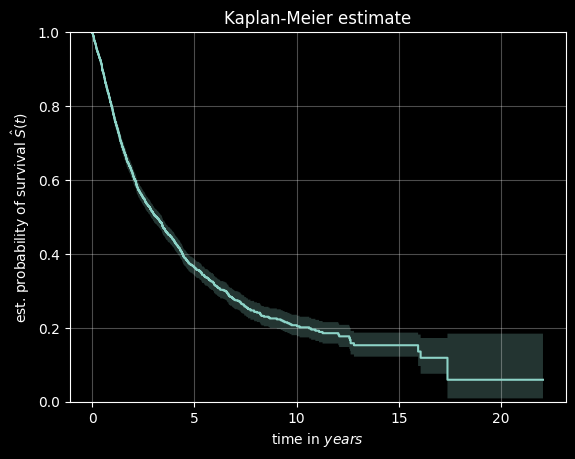

In [687]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    target_df["OS_STATUS"].astype(bool), target_df["OS_YEARS"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time in $years$")
plt.title("Kaplan-Meier estimate")
plt.grid(alpha=0.3)
plt.show()

In [688]:
class CoxModelEvaluator:
    def __init__(self, X, y, n_splits=5, random_state=0):
        self.X = X
        self.y = y
        self.kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.cox_cindex_c_train_scores = []
        self.cox_cindex_c_test_scores = []
        self.alpha = 0
        self.cox_c = CoxPHSurvivalAnalysis(alpha=self.alpha)

    def evaluate_model(self, imputer=KNNImputer(n_neighbors=4),alpha=0):
        self.alpha = alpha
        self.cox_cindex_c_train_scores = [] # Rest previous scores
        self.cox_cindex_c_test_scores = []
        for train_index, test_index in self.kf.split(self.X,self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            imputer = imputer
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)

            self.cox_c.fit(X_train, y_train)

            cox_cindex_c_train = concordance_index_ipcw(y_train, y_train, self.cox_c.predict(X_train), tau=7)[0]
            cox_cindex_c_test = concordance_index_ipcw(y_train, y_test, self.cox_c.predict(X_test), tau=7)[0]

            self.cox_cindex_c_train_scores.append(cox_cindex_c_train)
            self.cox_cindex_c_test_scores.append(cox_cindex_c_test)

        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on train: {np.mean(self.cox_cindex_c_train_scores):.2f}")
        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on test: {np.mean(self.cox_cindex_c_test_scores):.2f}")

In [689]:
import re
def parse_cytogenetics(cytogenetics_str):
    modal_number_match = re.search(r'^\d+', cytogenetics_str)
    modal_number = modal_number_match.group() if modal_number_match else None  # Extract modal number
    sex_chromosomes_match = re.search(r'(xx|xy)', cytogenetics_str, re.IGNORECASE)
    sex_chromosomes = sex_chromosomes_match.group() if sex_chromosomes_match else None  # Extract sex chromosomes
    abnormalities = re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', cytogenetics_str)
    subclones = re.findall(r'/\d+', cytogenetics_str)
    return {
        "modal_number": modal_number,
        "sex_chromosomes": sex_chromosomes,
        "abnormalities": abnormalities,
        "subclones": subclones
    }

# Example input
cytogenetics_str = clinical_df['CYTOGENETICS'].iloc[2]
parsed = parse_cytogenetics(cytogenetics_str)
print(parsed)


clinical_df['CYTOGENETICS'] = clinical_df['CYTOGENETICS'].fillna('NA')
# Add gender column while being careful about the None type, give an average if unknown
clinical_df['GENDER'] = clinical_df['CYTOGENETICS'].apply(lambda x: 1 if re.search(r'xy', x, re.IGNORECASE) \
    else (0 if re.search(r'xx', x, re.IGNORECASE) else 0.5))

# Add number of abnormalities column
clinical_df['NUM_ABNORMALITIES'] = clinical_df['CYTOGENETICS'].apply(lambda x: len(re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', x)))

# Add number of chromosomes over or under 46 column
clinical_df['CHROMOSOME_DIFF'] = clinical_df['CYTOGENETICS'].apply(lambda x: abs(int(re.search(r'^\d+', x).group()) - 46) if re.search(r'^\d+', x) else 0)

{'modal_number': '46', 'sex_chromosomes': 'xy', 'abnormalities': ['t(3;3)'], 'subclones': ['/46']}


In [690]:
X = clinical_df.loc[clinical_df['ID'].isin(target_df['ID'])].copy()
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)


tmp = molecular_df.groupby('ID').size().reset_index(name='Nb mut')
X = X.merge(tmp, on='ID', how='left').fillna({'Nb mut': 0})

# X = X.drop(columns=['CYTOGENETICS','ID','GENDER','CENTER'])


In [691]:
X['MONOSOMY 9'] = X['CYTOGENETICS'].str.contains('-9').fillna(False).map({True: 1, False: 0})
X['MONOSOMY 7'] = X['CYTOGENETICS'].str.contains('-7').fillna(False).map({True: 1, False: 0})


In [692]:
"""
mol_avg_vaf = molecular_df.groupby('ID')['VAF'].mean().reset_index()
mol_avg_vaf.columns = ['ID', 'avg_VAF'] 
X = X.merge(mol_avg_vaf, on='ID', how='left').fillna({'VAF': 0})
"""
mol_sum_vaf = molecular_df.groupby('ID')['VAF'].sum().reset_index()
mol_sum_vaf.columns = ['ID', 'sum_VAF']
X = X.merge(mol_sum_vaf, on='ID', how='left').fillna({'VAF': 0})

mol_sum_depth = molecular_df.groupby('ID')['DEPTH'].sum().reset_index()
mol_sum_depth.columns = ['ID', 'sum_depth']
X = X.merge(mol_sum_depth, on='ID', how='left').fillna({'VAF': 0})

molecular_df['X_mutation'] = molecular_df['CHR'].apply(lambda x: 1 if x == 'X' else 0)
mol_sum_X = molecular_df.groupby('ID')['X_mutation'].sum().reset_index()
mol_sum_X.columns = ['ID', 'sum_X']
X = X.merge(mol_sum_X, on='ID', how='left').fillna({'sum_X': 0})

In [693]:
coords = molecular_df[['CHR', 'START', 'END']].copy()
coords['CHR'] = coords['CHR'].fillna(0).apply(lambda x: float(23) if x == 'X' else float(x))
coords['START'] = coords['START'].fillna(coords['START'].mean())
coords['END'] = coords['END'].fillna(coords['END'].mean())

scaler = RobustScaler()
coords_scaled = scaler.fit_transform(coords)

dbscan = DBSCAN(eps=0.5, min_samples=6)
clusters = dbscan.fit_predict(coords_scaled)
coords['Cluster'] = clusters
coords.head()

molecular_df['Cluster'] = coords['Cluster']

In [694]:
#One hot encoding
categorical_cols = ['CHR','GENE','EFFECT','REF','ALT','Cluster','PROTEIN_CHANGE']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(molecular_df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
encoded_df['ID'] = molecular_df['ID']
encoded_group = encoded_df.groupby('ID').sum().reset_index()

"""
mca = MCA(n_components=10, n_iter=100, random_state=42) 
mca_features = mca.fit_transform(encoded_group.drop(columns=['ID']))
encoded_group = pd.DataFrame(mca_features, columns=[f'MCA_{i}' for i in range(mca_features.shape[1])])
encoded_group['ID'] = molecular_df['ID'].unique()
"""

"\nmca = MCA(n_components=10, n_iter=100, random_state=42) \nmca_features = mca.fit_transform(encoded_group.drop(columns=['ID']))\nencoded_group = pd.DataFrame(mca_features, columns=[f'MCA_{i}' for i in range(mca_features.shape[1])])\nencoded_group['ID'] = molecular_df['ID'].unique()\n"

In [695]:
encoded_group.head()

,ID,CHR_1,CHR_10,CHR_11,CHR_12,CHR_13,CHR_14,CHR_15,CHR_16,CHR_17,...,PROTEIN_CHANGE_p.Y874*,PROTEIN_CHANGE_p.Y889*,PROTEIN_CHANGE_p.Y899*,PROTEIN_CHANGE_p.Y89fs*44,PROTEIN_CHANGE_p.Y908C,PROTEIN_CHANGE_p.Y93fs*5,PROTEIN_CHANGE_p.Y974*,PROTEIN_CHANGE_p.Y974fs*10,PROTEIN_CHANGE_p.Y974fs*8,PROTEIN_CHANGE_nan
0,P100000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P100006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [696]:
encoded_group = encoded_group.drop(columns=[col for col in encoded_group.drop(['ID'],axis=1).columns if encoded_group[col].sum() <= 5])
X = X.merge(encoded_group, on='ID', how='left')#.fillna(0)
#rare_columns = [col for col in X.drop(['ID', 'CENTER', 'CYTOGENETICS'], axis=1).columns if X[col].sum() <= 10]
#X = X.drop(columns=rare_columns)

In [697]:
nan_counts = X.isna().sum().sum()
print(nan_counts)

100042


In [698]:
encoded_df.head()

,CHR_1,CHR_10,CHR_11,CHR_12,CHR_13,CHR_14,CHR_15,CHR_16,CHR_17,CHR_18,...,PROTEIN_CHANGE_p.Y889*,PROTEIN_CHANGE_p.Y899*,PROTEIN_CHANGE_p.Y89fs*44,PROTEIN_CHANGE_p.Y908C,PROTEIN_CHANGE_p.Y93fs*5,PROTEIN_CHANGE_p.Y974*,PROTEIN_CHANGE_p.Y974fs*10,PROTEIN_CHANGE_p.Y974fs*8,PROTEIN_CHANGE_nan,ID
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000


In [699]:
molecular_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH,X_mutation,Cluster
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0,0,0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0,0,0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0,0,0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0,0,0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0,0,0


In [700]:
molecular_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH,X_mutation,Cluster
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0,0,0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0,0,0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0,0,0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0,0,0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0,0,0


In [701]:
molecular_df['PROTEIN_CHANGE'].value_counts()

PROTEIN_CHANGE
p.?                  529
p.K700E              426
p.G646fs*12          370
p.P95H               246
p.P95L               148
                    ... 
p.L1244P               1
p.R1571fs*25           1
p.A258fs*3             1
p.E856fs*7             1
p.L1151_G1152insE      1
Name: count, Length: 4686, dtype: int64

In [702]:
X.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,GENDER,...,PROTEIN_CHANGE_p.Y1245fs*22,PROTEIN_CHANGE_p.Y1255fs*1,PROTEIN_CHANGE_p.Y220C,PROTEIN_CHANGE_p.Y591*,PROTEIN_CHANGE_p.Y591D,PROTEIN_CHANGE_p.Y591fs*1,PROTEIN_CHANGE_p.Y623C,PROTEIN_CHANGE_p.Y638C,PROTEIN_CHANGE_p.Y735C,PROTEIN_CHANGE_nan
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


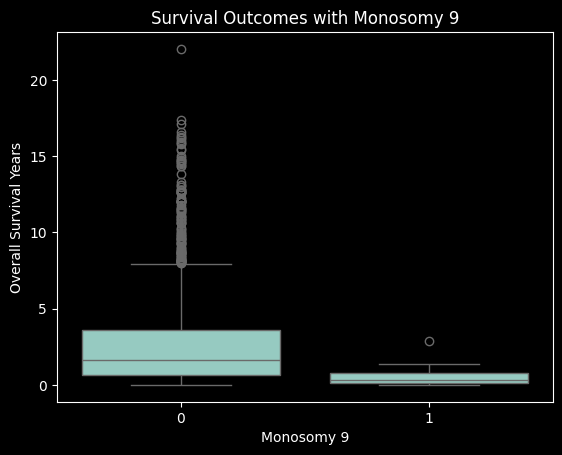

In [703]:
merged_mono = X.merge(target_df[['ID','OS_YEARS']], on='ID')
sns.boxplot(x='MONOSOMY 9', y='OS_YEARS', data=merged_mono)
plt.title('Survival Outcomes with Monosomy 9')
plt.xlabel('Monosomy 9')
plt.ylabel('Overall Survival Years')
plt.show()


c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


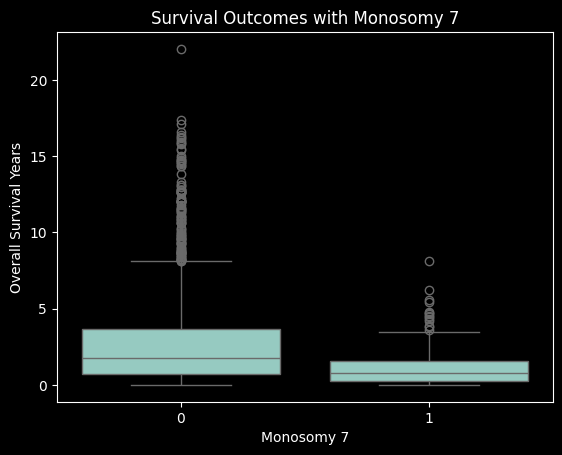

In [704]:
merged_mono = X.merge(target_df[['ID','OS_YEARS']], on='ID')
sns.boxplot(x='MONOSOMY 7', y='OS_YEARS', data=merged_mono)
plt.title('Survival Outcomes with Monosomy 7')
plt.xlabel('Monosomy 7')
plt.ylabel('Overall Survival Years')
plt.show()


In [705]:
"""
merged = X.merge(target_df, on='ID', how='left')
correlation_matrix = merged.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
"""

'\nmerged = X.merge(target_df, on=\'ID\', how=\'left\')\ncorrelation_matrix = merged.corr()\nplt.figure(figsize=(12, 10))\nsns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\')\nplt.title(\'Correlation Matrix\')\nplt.show()\n'

In [706]:
drop_features = ['ID', 'CENTER', 'CYTOGENETICS']
X = X.drop(columns=drop_features)

In [707]:
"""
evaluator = CoxModelEvaluator(X, y)
evaluator.evaluate_model(imputer=KNNImputer(n_neighbors=10),alpha=0.000001)
"""

'\nevaluator = CoxModelEvaluator(X, y)\nevaluator.evaluate_model(imputer=KNNImputer(n_neighbors=10),alpha=0.000001)\n'

#### Feature Importance

In [708]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [709]:
imputer = SimpleImputer(strategy="mean")
#imputer = KNNImputer(n_neighbors=6)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [710]:
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
y_train_lgb = y_train['OS_STATUS']

train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgbm_model = lgb.train(lgbm_params, train_data, num_boost_round=1000)

train_ci_ipcw = concordance_index_ipcw(y_train, y_train, lgbm_model.predict(X_train_lgb), tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, lgbm_model.predict(X_test_lgb), tau=7)[0]
print(f"Train CI IPCW: {train_ci_ipcw:.4f}")
print(f"Test CI IPCW: {test_ci_ipcw:.4f}")

Train CI IPCW: 0.8194
Test CI IPCW: 0.6653


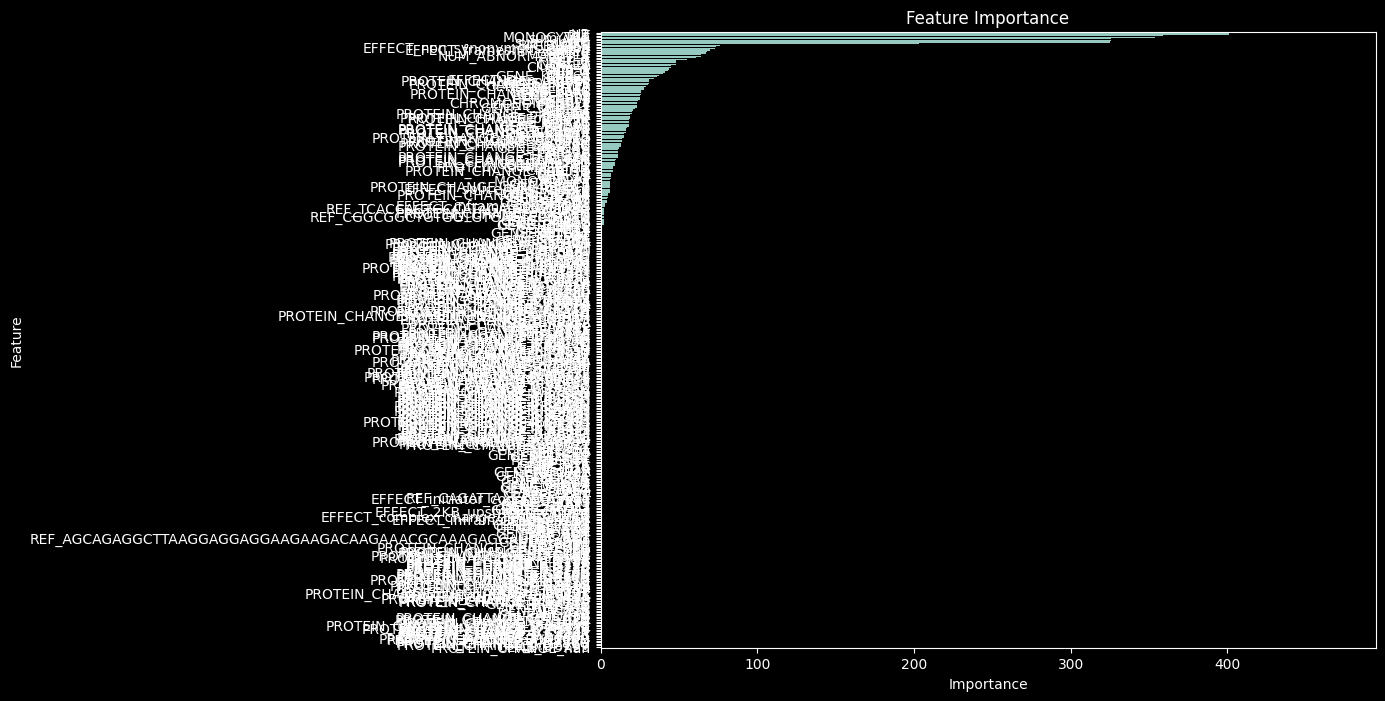

In [711]:
# Get feature importance
importance = lgbm_model.feature_importance()
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the feature importance dataframe
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_lgb)
plt.title('Feature Importance')
plt.show()

In [712]:
rf_params = {
    'max_depth': 3,
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': -1
}

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train['OS_YEARS'])

train_ci_ipcw_rf = concordance_index_ipcw(y_train, y_train, rf_model.predict(X_train), tau=7)[0]
test_ci_ipcw_rf = concordance_index_ipcw(y_train, y_test, rf_model.predict(X_test), tau=7)[0]
print(f"Train CI IPCW RF: {train_ci_ipcw_rf:.4f}")
print(f"Test CI IPCW RF: {test_ci_ipcw_rf:.4f}")

Train CI IPCW RF: 0.2924
Test CI IPCW RF: 0.3252


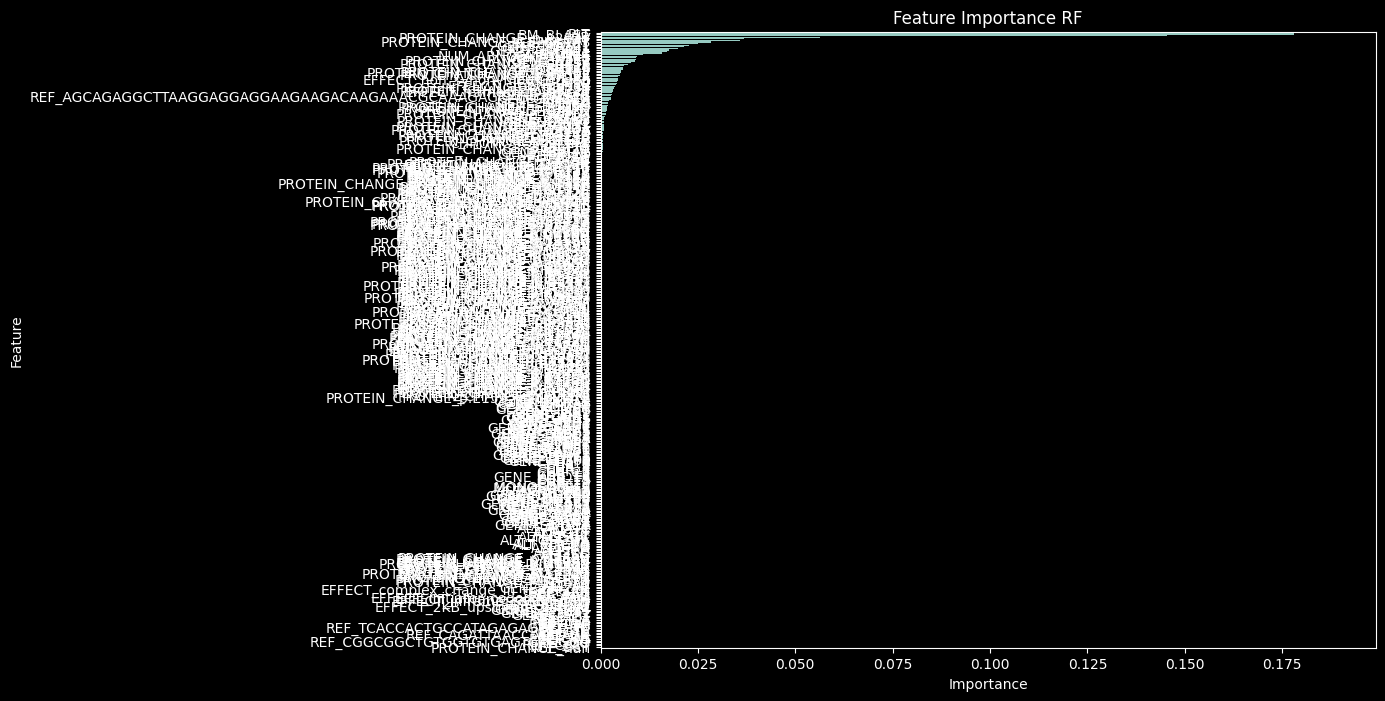

In [713]:
# Get feature importance
importance_rf = rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance_rf})
# Sort the feature importance dataframe
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf)
plt.title('Feature Importance RF')
plt.show()


In [714]:
feature_importance_df_lgb.head(20)

,Feature,Importance
4,HB,471
5,PLT,401
3,MONOCYTES,359
12,sum_VAF,354
2,ANC,326
13,sum_depth,326
1,WBC,325
0,BM_BLAST,203
6,GENDER,76
137,EFFECT_non_synonymous_codon,74


In [715]:
feature_importance_df_rf.head(20)

,Feature,Importance
5,PLT,0.189470
0,BM_BLAST,0.177926
4,HB,0.145298
209,PROTEIN_CHANGE_p.A213V,0.056250
12,sum_VAF,0.036715
226,PROTEIN_CHANGE_p.E261fs*3,0.035743
164,REF_GCTCT,0.028281
27,CHR_21,0.025051
59,GENE_DDX41,0.022588
110,GENE_SF3B1,0.021482


In [716]:
columns_to_use = feature_importance_df_lgb['Feature'].head(30).values
columns_to_use

array(['HB', 'PLT', 'MONOCYTES', 'sum_VAF', 'ANC', 'sum_depth', 'WBC',
       'BM_BLAST', 'GENDER', 'EFFECT_non_synonymous_codon',
       'EFFECT_frameshift_variant', 'CHR_4', 'REF_C', 'CHR_17',
       'NUM_ABNORMALITIES', 'ALT_A', 'REF_A', 'ALT_C', 'REF_T', 'Nb mut',
       'CHR_21', 'Cluster_0', 'sum_X', 'ALT_G', 'REF_G', 'ALT_T', 'CHR_5',
       'GENE_KDM6A', 'CHR_2', 'EFFECT_stop_gained'], dtype=object)

## Training

#### Random Survival Forest

In [717]:
class RandomSurvivalForestEvaluator:
    def __init__(self, X, y, n_estimators=200, min_samples_split=30, min_samples_leaf=15, max_features=0.5, random_state=42, n_jobs=-1, n_splits=5, imputer=KNNImputer(n_neighbors=6)):
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.rsf = RandomSurvivalForest(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=random_state,
            n_jobs=n_jobs
        )
        self.rsf_cindex_train = []
        self.rsf_cindex_test = []
        self.imputer = imputer

    def train(self):
        for train_index, test_index in self.kf.split(self.X, self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            imputer = self.imputer
            #imputer = SimpleImputer(strategy='mean')
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            self.rsf.fit(X_train, y_train)

            rsf_cindex_train_val = concordance_index_ipcw(y_train, y_train, self.rsf.predict(X_train), tau=7)[0]
            rsf_cindex_test_val = concordance_index_ipcw(y_train, y_test, self.rsf.predict(X_test), tau=7)[0]
            self.rsf_cindex_train.append(rsf_cindex_train_val)
            self.rsf_cindex_test.append(rsf_cindex_test_val)

    def get_scores(self):
        print(f"Average Random Survival Forest IPCW-Index train: {np.mean(self.rsf_cindex_train):.4f}")
        print(f"Average Random Survival Forest IPCW-Index test: {np.mean(self.rsf_cindex_test):.4f}")
    
    def score_reset(self):
        self.rsf_cindex_test = []
        self.rsf_cindex_train = []

In [718]:
def grid_search_rsf(X, y, param_grid, n_splits=5, tau=7):
    """
    Perform grid search on RandomSurvivalForest with IPCW concordance index.

    Parameters:
    - X: DataFrame or array-like, feature matrix.
    - y: Structured array, survival data in sksurv format.
    - param_grid: Dictionary, parameter grid for RSF.
    - n_splits: Int, number of folds for cross-validation.
    - tau: Float, IPCW truncation time.

    Returns:
    - best_params: Dictionary, best parameter combination.
    - best_score: Float, best test concordance index score.
    """
    # Generate all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # for later update of best score and parameters
    best_score = -np.inf
    best_params = None
    n = len(param_combinations)
    i = 0
    for params in param_combinations:
        # Initialize RSF with current parameter set
        rsf_params = dict(zip(param_names, params))
        rsf = RandomSurvivalForest(**rsf_params, random_state=42, n_jobs=-1)

        # Cross-validation setup
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        train_scores = []
        test_scores = []

        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Handle missing data
            imputer = SimpleImputer(strategy="mean")
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            
            # Fit RSF model
            rsf.fit(X_train, y_train)

            # Evaluate IPCW concordance index
            train_score = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train), tau=tau)[0]
            test_score = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test), tau=tau)[0]

            train_scores.append(train_score)
            test_scores.append(test_score)
        i += 1
        print(f"step {i}/{n}")
        # Average test score for this parameter set
        mean_test_score = np.mean(test_scores)
        print(f"Params: {rsf_params}, Train Score: {np.mean(train_scores):.4f}, Test Score: {mean_test_score:.4f}")

        # Update best parameters if the current score is better
        if mean_test_score > best_score:
            best_score = mean_test_score
            best_params = rsf_params

    return best_params, best_score


In [720]:
X_used = X.loc[:, columns_to_use]

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_used)
X_scaled = pd.DataFrame(X_scaled, columns=X_used.columns)
evaluator = RandomSurvivalForestEvaluator(X_scaled, y)
evaluator.train()

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [722]:
evaluator.get_scores()

Average Random Survival Forest IPCW-Index train: 0.7966
Average Random Survival Forest IPCW-Index test: 0.7125


In [723]:
scaler = RobustScaler()
X_ = scaler.fit_transform(X)
X_ = pd.DataFrame(X_, columns=X.columns)

In [724]:
eval_rsf = RandomSurvivalForestEvaluator(X_, y,imputer=KNNImputer(n_neighbors=10))
eval_rsf.train()
eval_rsf.get_scores()


c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average Random Survival Forest IPCW-Index train: 0.7995
Average Random Survival Forest IPCW-Index test: 0.7158


In [616]:
"""
pca = PCA(0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)
X_pca = pd.DataFrame(X_pca)
eval_rsf_pca = RandomSurvivalForestEvaluator(X_pca, y)
eval_rsf_pca.train()
eval_rsf_pca.get_scores()
"""

'\npca = PCA(0.95)\nX_pca = pca.fit_transform(X)\nprint(X_pca.shape)\nprint(pca.explained_variance_ratio_)\nX_pca = pd.DataFrame(X_pca)\neval_rsf_pca = RandomSurvivalForestEvaluator(X_pca, y)\neval_rsf_pca.train()\neval_rsf_pca.get_scores()\n'

In [617]:
param_grid = {
    "n_estimators": [100,200],
    "min_samples_split": [5, 10,30],
    "min_samples_leaf": [2, 5,20],
    "max_features": ["sqrt"],
    "max_depth": [None, 5, 15]
}

#best_params, best_score = grid_search_rsf(X, y, param_grid, n_splits=5, tau=7)

#print("\nBest Parameters:", best_params)
#print("Best Test Concordance Index:", best_score)


#### Gradient Boosting Survival Analysis

In [725]:
param = {'n_estimators': 185,
  'learning_rate': 0.05,
  'max_depth': 3,
  'subsample': 0.8}

est_cph_tree = GradientBoostingSurvivalAnalysis(**param,random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)

gbs_cindex_test_val = concordance_index_ipcw(y_train, y_test, est_cph_tree.predict(X_test), tau=7)[0]
gbs_cindex_train_val = concordance_index_ipcw(y_train, y_train, est_cph_tree.predict(X_train), tau=7)[0]

print(round(cindex, 4))
print(f'train ipcw score : {round(gbs_cindex_train_val, 4)}')
print(f'test ipcw score : {round(gbs_cindex_test_val, 4)}')



0.7373
train ipcw score : 0.7756
test ipcw score : 0.7111


In [619]:
def grid_search_gbs(X, y, param_grid, n_splits=5, tau=7):
    """
    Perform grid search on RandomSurvivalForest with IPCW concordance index.

    Parameters:
    - X: DataFrame or array-like, feature matrix.
    - y: Structured array, survival data in sksurv format.
    - param_grid: Dictionary, parameter grid for gbs.
    - n_splits: Int, number of folds for cross-validation.
    - tau: Float, IPCW truncation time.

    Returns:
    - best_params: Dictionary, best parameter combination.
    - best_score: Float, best test concordance index score.
    """
    # Generate all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # for later update of best score and parameters
    best_score = -np.inf
    best_params = None
    n = len(param_combinations)
    i = 0
    for params in param_combinations:
        gbs_params = dict(zip(param_names, params))
        gbs = GradientBoostingSurvivalAnalysis(**gbs_params, random_state=42)

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        train_scores = []
        test_scores = []

        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            imputer = KNNImputer(n_neighbors=15)
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            
            gbs.fit(X_train, y_train)

            train_score = concordance_index_ipcw(y_train, y_train, gbs.predict(X_train), tau=tau)[0]
            test_score = concordance_index_ipcw(y_train, y_test, gbs.predict(X_test), tau=tau)[0]

            train_scores.append(train_score)
            test_scores.append(test_score)
        i += 1
        print(f"step {i}/{n}")

        mean_test_score = np.mean(test_scores)
        print(f"Params: {gbs_params}, Train Score: {np.mean(train_scores):.4f}, Test Score: {mean_test_score:.4f}")

        if mean_test_score > best_score:
            best_score = mean_test_score
            best_params = gbs_params

    return best_params, best_score

In [620]:
#without protein_changes 
print(({'n_estimators': 50, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8},
 0.7182145046514242))


({'n_estimators': 50, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8}, 0.7182145046514242)


In [621]:
#with protein_changes
print(({'n_estimators': 150,
  'learning_rate': 0.05,
  'max_depth': 3,
  'subsample': 0.8},
 0.7184572349665073))

({'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8}, 0.7184572349665073)


In [622]:
param_grid_gbs = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0]
}

#grid_search_gbs(X_, y, param_grid_gbs, n_splits=5, tau=7)

In [726]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_index, test_index in kf.split(X_, y):
    X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    imputer = KNNImputer(n_neighbors=10)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    est_cph_tree.fit(X_train, y_train)
    cindex = est_cph_tree.score(X_test, y_test)

    gbs_cindex_test_val = concordance_index_ipcw(y_train, y_test, est_cph_tree.predict(X_test), tau=7)[0]
    gbs_cindex_train_val = concordance_index_ipcw(y_train, y_train, est_cph_tree.predict(X_train), tau=7)[0]

    scores.append((cindex, gbs_cindex_train_val, gbs_cindex_test_val))

avg_cindex = np.mean([score[0] for score in scores])
avg_train_ipcw = np.mean([score[1] for score in scores])
avg_test_ipcw = np.mean([score[2] for score in scores])

print(f'Average C-index: {round(avg_cindex, 4)}')
print(f'Average train IPCW score: {round(avg_train_ipcw, 4)}')
print(f'Average test IPCW score: {round(avg_test_ipcw, 4)}')

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average C-index: 0.7377
Average train IPCW score: 0.7694
Average test IPCW score: 0.7181


In [727]:
scores

[(0.7322244262861927, 0.7688732824079666, 0.7255882195603236),
 (0.7134618770910371, 0.7719429536272095, 0.6981222771914529),
 (0.7411855723599173, 0.7673698899369945, 0.7265483786291592),
 (0.7518925166136955, 0.771266489403034, 0.7170058604863382),
 (0.749957117966218, 0.7677137750091318, 0.7233176776502082)]

In [625]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=3, random_state=0)
for i in range(1, 2):
    n_estimators = i * 10
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = concordance_index_ipcw(y_train, y_test, est_cph_tree.predict(X_test), tau=7)[0]
    #scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

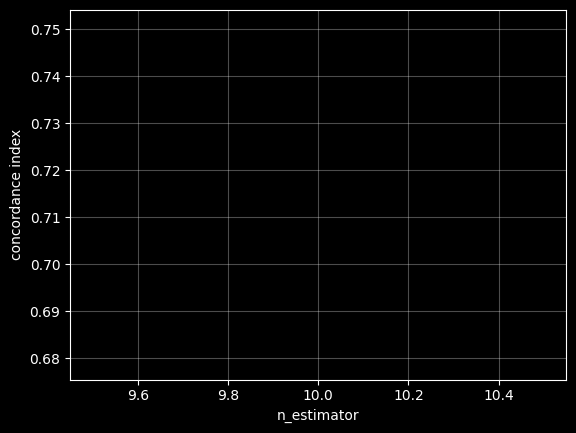

In [626]:
x_p, y_p = zip(*scores_cph_tree.items())
plt.plot(x_p, y_p)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(alpha=0.3)
plt.show()

In [627]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.8, max_depth=3, random_state=0
)

monitor = EarlyStoppingMonitor(10, 5)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)
ipcw_test = concordance_index_ipcw(y_train, y_test, est_early_stopping.predict(X_test), tau=7)[0]
cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 43))
print("IPCW concordance index", round(ipcw_test, 4))

Fitted base learners: 185
Performance on test set 0.7560147694752142
IPCW concordance index 0.7292


### TEST

In [628]:
print(molecular_test_df.isna().sum().sum())
print(clinical_test_df.isna().sum().sum())

550
1593


In [629]:
clinical_test_df.head(10)

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]"
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de..."
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8"
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r..."
5,KYW6,KYW,27.0,1.35,0.3915,NaN,4.1,148.0,Normal
6,KYW7,KYW,2.0,6.90,5.2095,NaN,7.5,94.0,"46,XY,del(11)(q?)"
7,KYW8,KYW,9.0,5.73,3.8391,NaN,7.8,195.0,"46,XY,del(5)(q13q15)[20]"
8,KYW9,KYW,2.0,NaN,NaN,NaN,NaN,NaN,Normal
9,KYW10,KYW,1.0,1.61,0.6118,NaN,9.9,85.0,"47,XY,+8"


In [630]:
molecular_test_df.head(10)

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,KYW961,1,1747229.0,1747229.0,T,C,GNB1,p.K57E,non_synonymous_codon,0.262,485.0
1,KYW142,1,1747229.0,1747229.0,T,C,GNB1,p.K57E,non_synonymous_codon,0.028,527.0
2,KYW453,1,1747229.0,1747229.0,T,C,GNB1,p.K57E,non_synonymous_codon,0.292,277.0
3,KYW982,1,1747229.0,1747229.0,T,C,GNB1,p.K57E,non_synonymous_codon,0.097,821.0
4,KYW845,1,36932209.0,36932209.0,G,A,CSF3R,p.Q754X,stop_gained,0.430,358.0
5,KYW907,1,36932209.0,36932209.0,G,A,CSF3R,p.Q754X,stop_gained,0.054,687.0
6,KYW926,1,36932213.0,36932213.0,A,-,CSF3R,p.Y752X,stop_gained,0.118,501.0
7,KYW12,1,36932213.0,36932213.0,-,T,CSF3R,p.Y752_G753delinsX,stop_gained,0.667,418.0
8,KYW810,1,36932215.0,36932215.0,-,TT,CSF3R,p.Y752fs,frameshift_variant,0.137,607.0
9,KYW810,1,36932219.0,36932219.0,-,C,CSF3R,p.V750fs,frameshift_variant,0.140,593.0


In [631]:
molecular_df['PROTEIN_CHANGE'].value_counts()[:20]

PROTEIN_CHANGE
p.?                      529
p.K700E                  426
p.G646fs*12              370
p.P95H                   246
p.P95L                   148
p.R140Q                  142
p.E635fs*15              114
p.Q157P                  102
p.S34F                    97
MLL_PTD                   89
p.V617F                   84
p.P95R                    83
p.G12D                    81
p.R882H                   81
p.D868N                   62
p.N244S                   61
p.P95_R102delPPDSHHSR     60
p.W288fs*12               57
p.H662Q                   55
p.K666N                   41
Name: count, dtype: int64

In [632]:
molecular_test_df['PROTEIN_CHANGE'].value_counts()[:20]

PROTEIN_CHANGE
p.L287fs       53
p.P95H         48
p.K700E        48
p.R525H        45
p.N155S        44
p.S34F         42
p.P499fs       40
p.R140Q        39
FLT3_ITD       36
MLL_PTD        33
p.Q157P        32
p.H630fs       30
p.R882H        29
p.G12D         25
p.R882C        24
p.V617F        23
p.P95L         21
p.G870S        20
p.95_103del    18
p.R132C        18
Name: count, dtype: int64

In [633]:
molecular_df['PROTEIN_CHANGE'].value_counts()

PROTEIN_CHANGE
p.?                  529
p.K700E              426
p.G646fs*12          370
p.P95H               246
p.P95L               148
                    ... 
p.L1244P               1
p.R1571fs*25           1
p.A258fs*3             1
p.E856fs*7             1
p.L1151_G1152insE      1
Name: count, Length: 4686, dtype: int64

In [728]:
clinical_test_df = pd.read_csv('Data/clinical_test.csv')
molecular_test_df = pd.read_csv('Data/molecular_test.csv')

In [729]:
known_protein_changes = set(molecular_df['PROTEIN_CHANGE'].unique())

#molecular_test_df['PROTEIN_CHANGE'] = molecular_test_df['PROTEIN_CHANGE'].apply(lambda x: x if x in known_protein_changes else 'p.?')

In [730]:
molecular_test_df['PROTEIN_CHANGE'].value_counts()

PROTEIN_CHANGE
p.L287fs    53
p.P95H      48
p.K700E     48
p.R525H     45
p.N155S     44
            ..
p.P419fs     1
p.R476X      1
p.E482fs     1
p.E491X      1
p.R232fs     1
Name: count, Length: 1589, dtype: int64

In [731]:
#TEST DF

clinical_test_df['CYTOGENETICS'] = clinical_test_df['CYTOGENETICS'].fillna('NA')
# Add gender column while being careful about the None type, give an average if unknown
clinical_test_df['GENDER'] = clinical_test_df['CYTOGENETICS'].apply(lambda x: 1 if re.search(r'xy', x, re.IGNORECASE) \
    else (0 if re.search(r'xx', x, re.IGNORECASE) else 0.5))

# Add number of abnormalities column
clinical_test_df['NUM_ABNORMALITIES'] = clinical_test_df['CYTOGENETICS'].apply(lambda x: len(re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', x)))

# Add number of chromosomes over or under 46 column
clinical_test_df['CHROMOSOME_DIFF'] = clinical_test_df['CYTOGENETICS'].apply(lambda x: abs(int(re.search(r'^\d+', x).group()) - 46) if re.search(r'^\d+', x) else 0)

# Handle 'Normal' values in 'CYTOGENETICS'
#clinical_test_df.loc[clinical_test_df['CYTOGENETICS'] == 'Normal', ['NUM_ABNORMALITIES', 'CHROMOSOME_DIFF', 'GENDER']] = [0, 0, 0.5]

X_test_sub = clinical_test_df.copy()

tmp_test = molecular_test_df.groupby('ID').size().reset_index(name='Nb mut')
X_test_sub = X_test_sub.merge(tmp_test, on='ID', how='left').fillna({'Nb mut': 0})

X_test_sub['MONOSOMY 9'] = X_test_sub['CYTOGENETICS'].str.contains('-9').fillna(False).map({True: 1, False: 0})
X_test_sub['MONOSOMY 7'] = X_test_sub['CYTOGENETICS'].str.contains('-7').fillna(False).map({True: 1, False: 0})

mol_sum_vaf_test = molecular_test_df.groupby('ID')['VAF'].sum().reset_index()
mol_sum_vaf_test.columns = ['ID', 'sum_VAF']
X_test_sub = X_test_sub.merge(mol_sum_vaf_test, on='ID', how='left').fillna({'VAF': 0})

mol_sum_depth_test = molecular_test_df.groupby('ID')['DEPTH'].sum().reset_index()
mol_sum_depth_test.columns = ['ID', 'sum_depth']
X_test_sub = X_test_sub.merge(mol_sum_depth_test, on='ID', how='left').fillna({'VAF': 0})

molecular_test_df['X_mutation'] = molecular_test_df['CHR'].apply(lambda x: 1 if x == 'X' else 0)
mol_sum_X_test = molecular_test_df.groupby('ID')['X_mutation'].sum().reset_index()
mol_sum_X_test.columns = ['ID', 'sum_X']
X_test_sub = X_test_sub.merge(mol_sum_X_test, on='ID', how='left').fillna({'sum_X': 0})




coords_test = molecular_test_df[['CHR', 'START', 'END']].copy()
coords_test['CHR'] = coords_test['CHR'].fillna(0).apply(lambda x: float(23) if x == 'X' else float(x))
coords_test['START'] = coords_test['START'].fillna(coords_test['START'].mean())
coords_test['END'] = coords_test['END'].fillna(coords_test['END'].mean())

scaler = RobustScaler()
coords_test_scaled = scaler.fit_transform(coords_test)

clusters_test = dbscan.fit_predict(coords_test_scaled)
coords_test['Cluster'] = clusters_test
coords_test.head()

molecular_test_df['Cluster'] = coords_test['Cluster']

categorical_cols_test = ['CHR','GENE','EFFECT','REF','ALT','Cluster','PROTEIN_CHANGE']


encoded_features_test = encoder.transform(molecular_test_df[categorical_cols_test])
encoded_test_df = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(categorical_cols_test))
encoded_test_df['ID'] = molecular_test_df['ID']
encoded_group_test = encoded_test_df.groupby('ID').sum().reset_index()

"""
drop_features_test = ['ID', 'CENTER', 'CYTOGENETICS']
X_test_sub = X_test_sub.drop(columns=drop_features_test)

col = X_test_sub.columns

scaler = StandardScaler()
X_test_sub = scaler.fit_transform(X_test_sub)
imputer = KNNImputer(n_neighbors=10)
X_test_sub = imputer.fit_transform(X_test_sub)
X_test_sub = pd.DataFrame(X_test_sub, columns=col)

X_test_sub['ID'] = clinical_test_df['ID']
"""

X_test_sub = X_test_sub.merge(encoded_group_test, on='ID', how='left')
#rare_columns_test = [col for col in X_test_sub.drop(['ID'], axis=1).columns if X_test_sub[col].sum() <= -100]
#X_test_sub = X_test_sub.drop(columns=rare_columns_test)

X_cols = set(X.columns)

# Drop columns that are not in X
X_test_sub = X_test_sub.drop(columns=[col for col in X_test_sub.columns if col not in X_cols])

# Add missing columns from X
for col in X_cols:
    if col not in X_test_sub.columns:
        X_test_sub[col] = 0

col_ = X_test_sub.columns
imputer = KNNImputer(n_neighbors=10)
X_test_sub = imputer.fit_transform(X_test_sub)

X_test_sub = scaler.fit_transform(X_test_sub)
X_test_sub = pd.DataFrame(X_test_sub, columns=col_)



In [732]:
X_.head()

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,GENDER,NUM_ABNORMALITIES,CHROMOSOME_DIFF,Nb mut,...,PROTEIN_CHANGE_p.Y1245fs*22,PROTEIN_CHANGE_p.Y1255fs*1,PROTEIN_CHANGE_p.Y220C,PROTEIN_CHANGE_p.Y591*,PROTEIN_CHANGE_p.Y591D,PROTEIN_CHANGE_p.Y591fs*1,PROTEIN_CHANGE_p.Y623C,PROTEIN_CHANGE_p.Y638C,PROTEIN_CHANGE_p.Y735C,PROTEIN_CHANGE_nan
0,1.571429,-0.325,-0.666667,0.513219,-0.807692,-0.024316,0.0,1.0,0.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.285714,0.825,0.148148,-0.419907,0.730769,-0.492401,-1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.714286,-0.100,0.037037,-0.419907,1.730769,-0.255319,0.0,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.285714,-0.050,-0.037037,-0.419907,-0.307692,-0.279635,0.0,1.0,0.0,2.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.428571,30.975,2.851852,0.824261,0.538462,0.437690,-1.0,1.0,0.0,-0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [733]:
X_test_sub

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,GENDER,NUM_ABNORMALITIES,CHROMOSOME_DIFF,Nb mut,...,PROTEIN_CHANGE_p.Y1245fs*22,PROTEIN_CHANGE_p.Y1255fs*1,PROTEIN_CHANGE_p.Y220C,PROTEIN_CHANGE_p.Y591*,PROTEIN_CHANGE_p.Y591D,PROTEIN_CHANGE_p.Y591fs*1,PROTEIN_CHANGE_p.Y623C,PROTEIN_CHANGE_p.Y638C,PROTEIN_CHANGE_p.Y735C,PROTEIN_CHANGE_nan
0,4.357143,0.101744,-0.412500,-0.355401,-0.371901,-0.316832,1.0,0.0,1.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.000000,0.023256,-0.092059,0.049551,0.619835,-0.475248,1.0,1.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.071429,2.703488,3.554902,0.286682,1.570248,-0.544554,-1.0,0.0,1.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.857143,0.712209,0.306618,4.338320,-0.206612,-0.356436,0.0,-0.5,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.357143,-0.549419,-0.338186,-0.244089,0.041322,-0.524752,1.0,1.5,3.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,-0.071429,0.743314,1.059417,-0.254664,0.545455,0.457426,0.0,-0.5,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1189,0.028571,1.759012,1.067444,0.197409,0.326446,0.670297,0.0,-0.5,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1190,-0.150000,0.231977,0.503502,-0.377540,-0.049587,0.145545,0.0,-0.5,0.0,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1191,0.257143,-0.197384,-0.195907,-0.252165,0.074380,0.773267,0.0,-0.5,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [734]:
eval_sub = est_cph_tree.predict(X_test_sub)

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


In [735]:
eval_sub = est_cph_tree.predict(X_test_sub)
submission = pd.Series(eval_sub, index=clinical_test_df['ID'], name='risk_score')
submission

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


ID
KYW1       1.140828
KYW2       0.428358
KYW3      -0.206711
KYW4       0.976147
KYW5       0.977020
             ...   
KYW1189   -0.770327
KYW1190   -0.262869
KYW1191   -0.717376
KYW1192   -0.124201
KYW1193    0.551136
Name: risk_score, Length: 1193, dtype: float64

In [736]:
submission.to_csv('submission5.csv')

### Features RSF

In [737]:
"""
from sklearn.inspection import permutation_importance
result = permutation_importance(eval_rsf.rsf, X_, y, n_repeats=1, random_state=42)
"""

'\nfrom sklearn.inspection import permutation_importance\nresult = permutation_importance(eval_rsf.rsf, X_, y, n_repeats=1, random_state=42)\n'

In [738]:
"""
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_.columns,
).sort_values(by="importances_mean", ascending=False)
"""

'\npd.DataFrame(\n    {\n        k: result[k]\n        for k in (\n            "importances_mean",\n            "importances_std",\n        )\n    },\n    index=X_.columns,\n).sort_values(by="importances_mean", ascending=False)\n'